# Recreate results from Obermeyer et al. (2019) - [Dissecting racial bias in an algorithm used to manage the health of populations](https://science.sciencemag.org/content/366/6464/447) using synthetic data

See an explanation for the `data_new.csv` synthetic data set here: https://gitlab.com/labsysmed/dissecting-bias/-/blob/master/data/data_dictionary.md

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
%matplotlib inline

In [4]:
ROOT = Path('..').resolve()

df = pd.read_csv(f'{ROOT}/data/data_new.csv')
df.sample(3)

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t
35812,0.186852,0,200.0,0.0,NaN,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
36984,0.798369,0,400.0,0.0,131.0,NaN,40.100000,0.95,119.0,white,...,0,0,0,0,0,0,0,0,0,0
7288,7.270256,0,3500.0,0.0,146.0,6.1,51.966667,1.16,73.5,white,...,0,0,0,0,0,0,0,0,1,3


In [5]:
white = df[df.race == 'white']
black = df[df.race == 'black']

len(white), len(black)

(43202, 5582)

In [7]:
white.cost_t.isna().sum()
black.cost_t.isna().sum()

0

# Figure 1a: Disparity in algorithmic risk score and number of chronic illnesses

In [142]:
# risk percentiles (every other)
percentiles = np.arange(0, 102, 2)
white_risk_pct = np.percentile(white.risk_score_t, percentiles)
black_risk_pct = np.percentile(black.risk_score_t, percentiles)

In [23]:
# number of active chronic illnesses vs risk percentiles
white_gagne_by_risk_pct = [
    np.average([white.gagne_sum_t[(white.risk_score_t < q) & (white.risk_score_t > p)]])\
        for p, q in zip(white_risk_pct[:-1], white_risk_pct[1:])
]

black_gagne_by_risk_pct = [
    np.average([black.gagne_sum_t[(black.risk_score_t < q) & (black.risk_score_t > p)]])\
        for p, q in zip(black_risk_pct[:-1], black_risk_pct[1:])
]

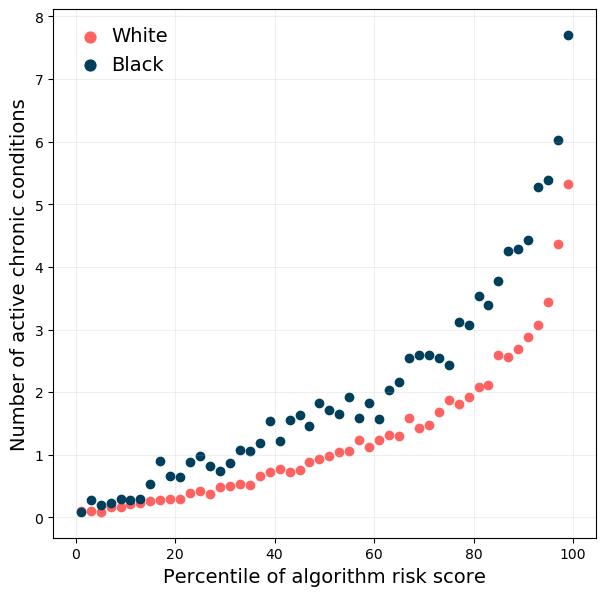

In [44]:
plt.figure(figsize=(7, 7), dpi=100)

plt.scatter(percentiles[:-1]+1, white_gagne_by_risk_pct, label='White', color='#ff6361')
plt.scatter(percentiles[:-1]+1, black_gagne_by_risk_pct, label='Black', color='#003f5c')

plt.ylabel('Number of active chronic conditions', fontsize=14)
plt.xlabel('Percentile of algorithm risk score', fontsize=14)

plt.legend(framealpha=0, markerscale=1.3, fontsize=14, handletextpad=0.1)
plt.grid('on', alpha=0.2);

This says that the disaggregated measure of outcomes, number of active chronic conditions at year $t$, is different for black and white patients, as a function of the algorithm's risk score, predicted using data from year $t-1$. 

[The paper](https://science.sciencemag.org/content/366/6464/447) proposes an explanation for why this happens (taken from the abstract): 
> The bias arises because the algorithm predicts health care costs rather than illness, but unequal access to care means that we spend less money caring for Black patients than for White patients. Thus, despite health care cost appearing to be an effective proxy for health by some measures of predictive accuracy, large racial biases arise.

Let's take a look at this proxy.

# Figure 3a: Medical expenses (objective function) are *not* disparate

In [148]:
# total costs (1000s of dollars) vs risk percentiles
white_cost_by_risk_pct = [
    np.average([white.cost_t[(white.risk_score_t < q) & (white.risk_score_t > p)]]) / 1e3\
        for p, q in zip(white_risk_pct[:-1], white_risk_pct[1:]) 
]

black_cost_by_risk_pct = [
    np.average([black.cost_t[(black.risk_score_t < q) & (black.risk_score_t > p)]]) / 1e3\
        for p, q in zip(black_risk_pct[:-1], black_risk_pct[1:]) 
]


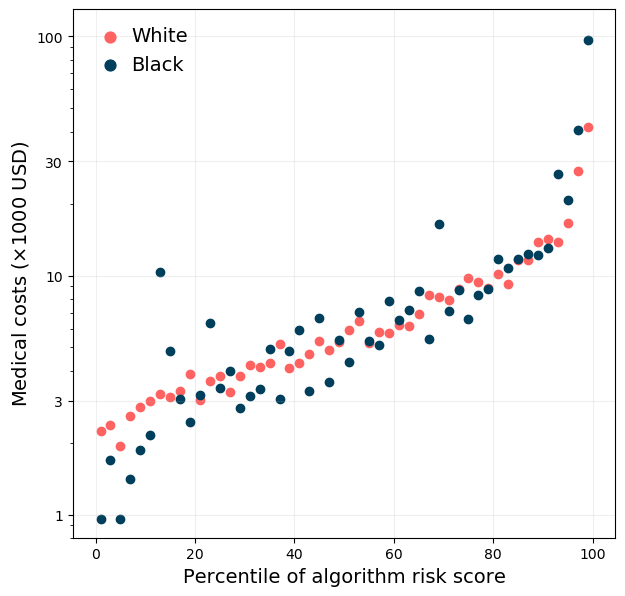

In [151]:
plt.figure(figsize=(7, 7), dpi=100)

plt.scatter(percentiles[:-1]+1, white_cost_by_risk_pct, label='White', color='#ff6361')
plt.scatter(percentiles[:-1]+1, black_cost_by_risk_pct, label='Black', color='#003f5c')

plt.ylabel(r'Medical costs ($\times$1000 USD)', fontsize=14)
plt.xlabel('Percentile of algorithm risk score', fontsize=14)

plt.ylim(0.8, 130)
plt.yscale('log')
plt.gca().set_yticks([1, 3, 10, 30, 100])
plt.gca().set_yticklabels([1, 3, 10, 30, 100])


plt.legend(framealpha=0, markerscale=1.3, fontsize=14, handletextpad=0.1)
plt.grid('on', alpha=0.2);

Note that I can use a median here in order to reduce the noise somewhat, and the mean and median trends are qualitatively similar. However, I want to stay true to the original paper's methods.

# Higher medical expenditures for white patients might explain the disparity between costs, chronic illnesses, and algorithm risks. 

This is shown in Figure 3b of the paper. I'm not a fan of making these plots a function of percentiles here, since there should be no trend across the >30% of patients who have zero chronic illnesses (and it's not clear how they ought to be ordered). We can still look at the difference between costs conditioned on the number of chronic illnesses:

In [69]:
white.gagne_sum_t.quantile(0.3),  black.gagne_sum_t.quantile(0.3)

(0.0, 0.0)

Numbers represent the sample size going into the average medical costs.

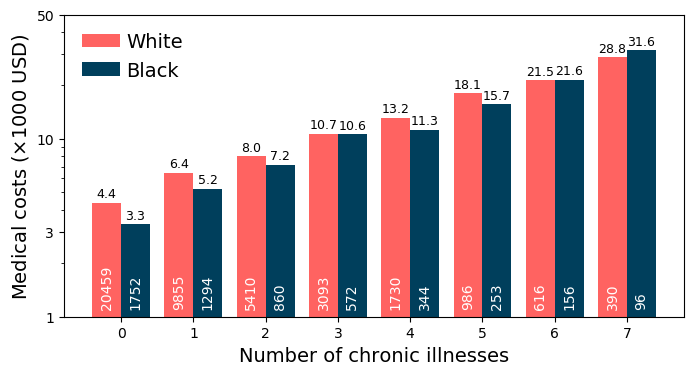

In [141]:
plt.figure(figsize=(8,4), dpi=100)

for x in range(0, 8):
   
    y_white = white[white.gagne_sum_t == x].cost_t.mean() / 1e3
    y_black = black[black.gagne_sum_t == x].cost_t.mean() / 1e3
    
    N_white = sum(white.gagne_sum_t == x)
    N_black = sum(black.gagne_sum_t == x)
    
    b = plt.bar(
        [x-0.2, x+0.2], 
        [y_white, y_black], 
        width=0.4,
        color=['#ff6361', '#003f5c'],
    )
    
    # mean costs
    plt.text(x-0.2, y_white * 1.07, f'{np.round(y_white, 1):.1f}', ha='center', color='black', fontsize=9)
    plt.text(x+0.2, y_black * 1.07, f'{np.round(y_black, 1):.1f}', ha='center', color='black', fontsize=9)
    
    # number of data points per bin
    plt.text(x-0.2, 1.15, f'{N_white:d}', ha='center', color='white', fontsize=10, rotation=90)
    plt.text(x+0.2, 1.15, f'{N_black:d}', ha='center', color='white', fontsize=10, rotation=90)
    

plt.ylim(1, 50)
plt.yscale('log')
plt.gca().set_yticks([1, 3, 10, 50])
plt.gca().set_yticklabels([1, 3, 10, 50])
plt.legend(b.patches, ['White', 'Black'], framealpha=0, markerscale=1.3, fontsize=14, handletextpad=0.3)

plt.ylabel(r'Medical costs ($\times$1000 USD)', fontsize=14)
plt.xlabel('Number of chronic illnesses', fontsize=14);

# Avoidable costs vs algorithm risk

In [153]:
# total costs vs risk percentiles
white_avcost_by_risk_pct = [
    np.average([white.cost_avoidable_t[(white.risk_score_t < q) & (white.risk_score_t > p)]]) / 1e3\
        for p, q in zip(white_risk_pct[:-1], white_risk_pct[1:])
]

black_avcost_by_risk_pct = [
    np.average([black.cost_avoidable_t[(black.risk_score_t < q) & (black.risk_score_t > p)]]) / 1e3\
        for p, q in zip(black_risk_pct[:-1], black_risk_pct[1:])
]


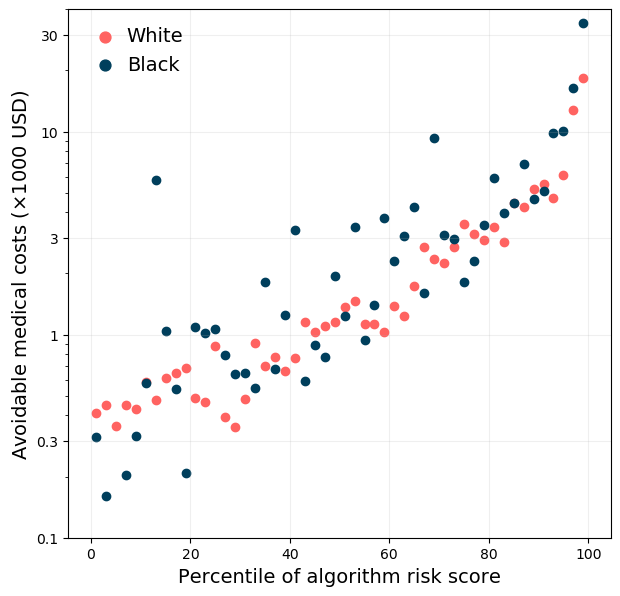

In [156]:
plt.figure(figsize=(7, 7), dpi=100)

plt.scatter(percentiles[:-1]+1, white_avcost_by_risk_pct, label='White', color='#ff6361')
plt.scatter(percentiles[:-1]+1, black_avcost_by_risk_pct, label='Black', color='#003f5c')

plt.ylabel(r'Avoidable medical costs ($\times$1000 USD)', fontsize=14)
plt.xlabel('Percentile of algorithm risk score', fontsize=14)

plt.yscale('log')
plt.ylim(0.1, 40)
plt.gca().set_yticks([0.1, 0.3, 1, 3, 10, 30])
plt.gca().set_yticklabels([0.1, 0.3, 1, 3, 10, 30])

plt.legend(framealpha=0, markerscale=1.3, fontsize=14, handletextpad=0.1)
plt.grid('on', alpha=0.2);

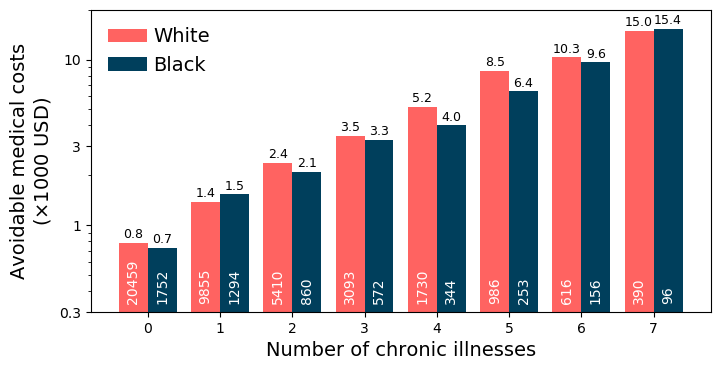

In [184]:
plt.figure(figsize=(8,4), dpi=100)

for x in range(0, 8):
   
    y_white = white[white.gagne_sum_t == x].cost_avoidable_t.mean() / 1e3
    y_black = black[black.gagne_sum_t == x].cost_avoidable_t.mean() / 1e3
    
    N_white = sum(white.gagne_sum_t == x)
    N_black = sum(black.gagne_sum_t == x)
    
    b = plt.bar(
        [x-0.2, x+0.2], 
        [y_white, y_black], 
        width=0.4,
        color=['#ff6361', '#003f5c'],
    )
    
    # mean costs
    plt.text(x-0.2, y_white * 1.07, f'{np.round(y_white, 1):.1f}', ha='center', color='black', fontsize=9)
    plt.text(x+0.2, y_black * 1.07, f'{np.round(y_black, 1):.1f}', ha='center', color='black', fontsize=9)
    
    # number of data points per bin
    plt.text(x-0.2, 0.35, f'{N_white:d}', ha='center', color='white', fontsize=10, rotation=90)
    plt.text(x+0.2, 0.35, f'{N_black:d}', ha='center', color='white', fontsize=10, rotation=90)
    

plt.ylim(0.3, 20)
plt.yscale('log')
plt.gca().set_yticks([0.3, 1, 3, 10])
plt.gca().set_yticklabels([0.3, 1, 3, 10])
plt.legend(b.patches, ['White', 'Black'], framealpha=0, markerscale=1.3, fontsize=14, handletextpad=0.3)

plt.ylabel('Avoidable medical costs\n'  r'($\times$1000 USD)', fontsize=14)
plt.xlabel('Number of chronic illnesses', fontsize=14);

# Diabetes severity vs algorithm risk (Fig 2b)

In [172]:
# total costs vs risk percentiles
white_diab_by_risk_pct = [
    np.nanmean([white.ghba1c_mean_t[(white.risk_score_t < q) & (white.risk_score_t > p)]])\
        for p, q in zip(white_risk_pct[:-1:], white_risk_pct[1:])
]

black_diab_by_risk_pct = [
    np.nanmean([black.ghba1c_mean_t[(black.risk_score_t < q) & (black.risk_score_t > p)]])\
        for p, q in zip(black_risk_pct[:-1], black_risk_pct[1:])
]


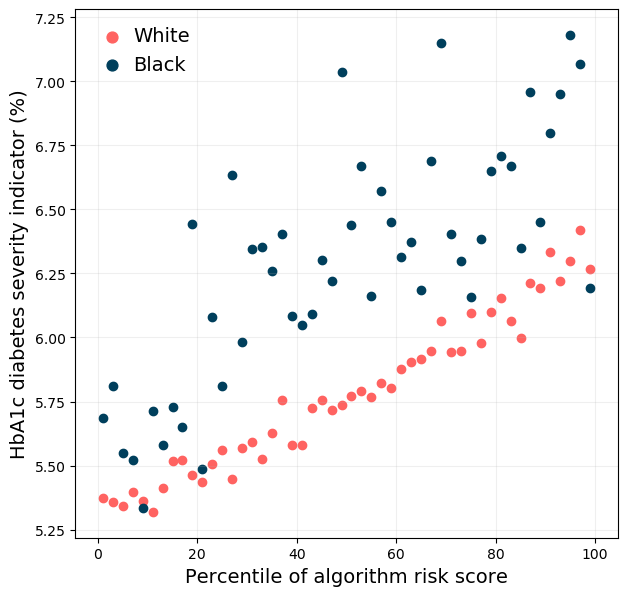

In [175]:
plt.figure(figsize=(7, 7), dpi=100)

plt.scatter(percentiles[:-1]+1, white_diab_by_risk_pct, label='White', color='#ff6361')
plt.scatter(percentiles[:-1]+1, black_diab_by_risk_pct, label='Black', color='#003f5c')

plt.ylabel('HbA1c diabetes severity indicator (%)', fontsize=14)
plt.xlabel('Percentile of algorithm risk score', fontsize=14)

plt.legend(framealpha=0, markerscale=1.3, fontsize=14, handletextpad=0.1)
plt.grid('on', alpha=0.2);

# Using median values

In [185]:
white_medcost_by_risk_pct = [
    np.median([white.cost_t[(white.risk_score_t < q) & (white.risk_score_t > p)]]) / 1e3\
        for p, q in zip(white_risk_pct[:-1], white_risk_pct[1:]) 
]

black_medcost_by_risk_pct = [
    np.median([black.cost_t[(black.risk_score_t < q) & (black.risk_score_t > p)]]) / 1e3\
        for p, q in zip(black_risk_pct[:-1], black_risk_pct[1:]) 
]


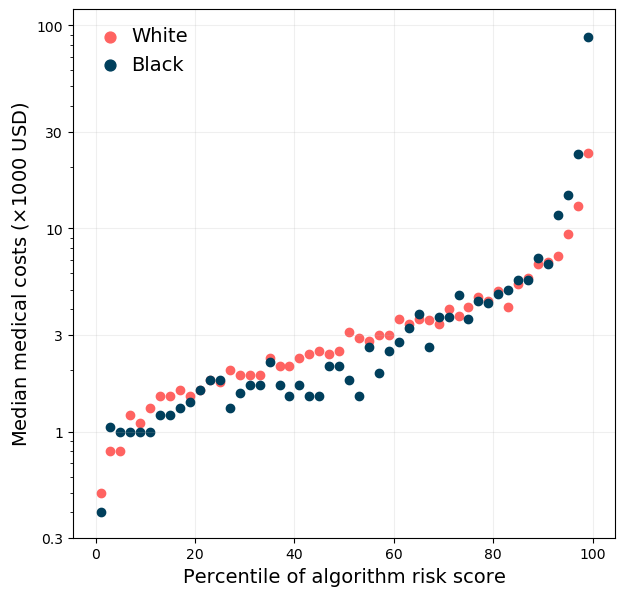

In [192]:
plt.figure(figsize=(7, 7), dpi=100)

plt.scatter(percentiles[:-1]+1, white_medcost_by_risk_pct, label='White', color='#ff6361')
plt.scatter(percentiles[:-1]+1, black_medcost_by_risk_pct, label='Black', color='#003f5c')

plt.ylabel(r'Median medical costs ($\times$1000 USD)', fontsize=14)
plt.xlabel('Percentile of algorithm risk score', fontsize=14)

plt.ylim(0.3, 120)
plt.yscale('log')
plt.gca().set_yticks([0.3, 1, 3, 10, 30, 100])
plt.gca().set_yticklabels([0.3, 1, 3, 10, 30, 100])


plt.legend(framealpha=0, markerscale=1.3, fontsize=14, handletextpad=0.1)
plt.grid('on', alpha=0.2);

In [199]:
white_meddiab_by_risk_pct = [
    np.nanmedian([white.ghba1c_mean_t[(white.risk_score_t < q) & (white.risk_score_t > p)]])\
        for p, q in zip(white_risk_pct[:-1:], white_risk_pct[1:])
]

black_meddiab_by_risk_pct = [
    np.nanmedian([black.ghba1c_mean_t[(black.risk_score_t < q) & (black.risk_score_t > p)]])\
        for p, q in zip(black_risk_pct[:-1], black_risk_pct[1:])
]


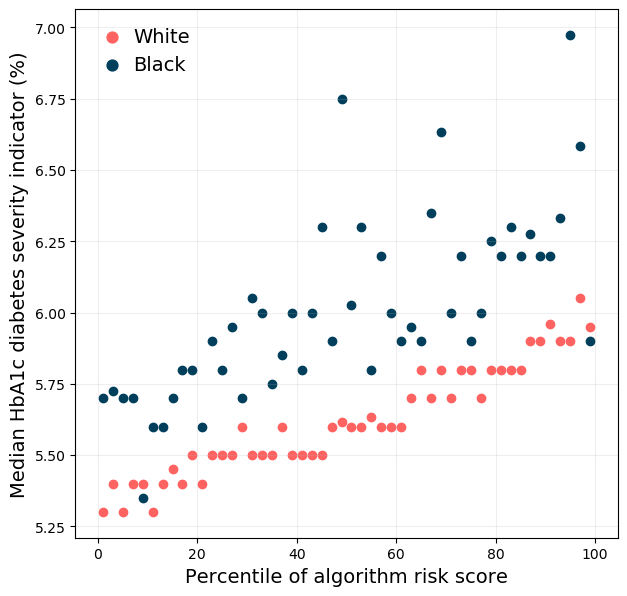

In [201]:
plt.figure(figsize=(7, 7), dpi=100)

plt.scatter(percentiles[:-1]+1, white_meddiab_by_risk_pct, label='White', color='#ff6361')
plt.scatter(percentiles[:-1]+1, black_meddiab_by_risk_pct, label='Black', color='#003f5c')

plt.ylabel('Median HbA1c diabetes severity indicator (%)', fontsize=14)
plt.xlabel('Percentile of algorithm risk score', fontsize=14)

plt.legend(framealpha=0, markerscale=1.3, fontsize=14, handletextpad=0.1)
plt.grid('on', alpha=0.2);